## Machine Learning with PySpark

**Course Structure:**
* Chapter 1. Introduction
* Chapter 2. Classification
* Chapter 3. Regression
* Chapter 4. Ensembles and Pipelines

### CHAPTER 1. Introduction

#### Part 1.1 Machine learning & Spark

* We will learn how to build **Machine Learning models** on *large data sets* using **distributed computing techniques**
* Performance of models depend on data, in general, more data is better
* If the data is too big, it cannot fit into RAM, it has to page between RAM and disk, which is slow
* We can distribute the data across multiple computers in a cluster   

**Spark:**
* Spark is a general purpose framework for cluster computing
* Popular for two reasons:
    1. Faster than other Big Data technologies because it does processing in memory
    2. Developer-friendly interface with well-documented high-level API
* It consists of one or more **nodes** and a cluster manager
* The manager allocates resource and coordinates activities across the cluster
* The driver program communicates with the manager

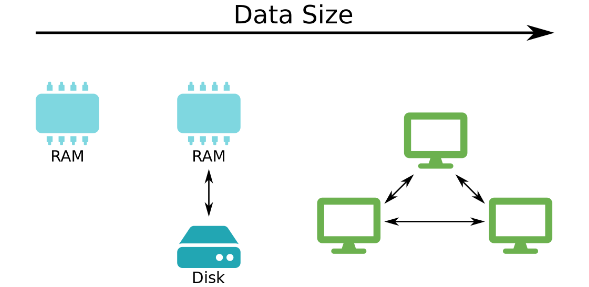

In [1]:
# display Spark approach for big data set
from IPython import display

display.Image("Images/22_spark.png")

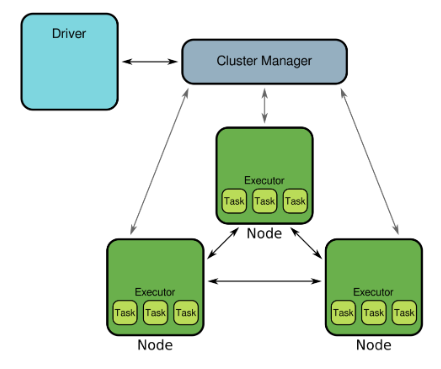

In [2]:
from IPython import display

display.Image("Images/22_spark_components.png")

#### Part 1.2 Connecting to Spark

* The connection with Spark is established by the **driver**, which can be written in Java, Scala, Python or R
* In Python, we use *'pyspark'* module
* Check version: *'pyspark.__version__'*
* *'pyspark'* has a few submodules to implement different aspects of Spark interface:
    * Structured Data: *'pyspark.sql'*
    * Streaming Data: *'pyspark.streaming'*
    * Machine Learning: *'pyspark.ml'*
* Tell the Spark where the cluster is located by providing a **Spark URL**, which can be remote or local
    * Remote Example: *'spark://<IP address | DNS name>:<port>'*
    * Local Example: *'local'* or *'local[4]'*
* Start by creating a SparkSession
    * Example: *'spark = SparkSession.builder.master('locao[*]').appName('first_spark_application).getOrCreate()'*
* Close connection to Spark after the work
    * Example: *'spark.stop()'*    

In [3]:
# Code for part 1.2

# creating a SparkSession
from pyspark.sql import SparkSession

# create SparkSession object
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

# version of Spark
print(spark.version)

# terminate the cluster
spark.stop()

3.5.0


#### Part 1.3 Loading data

* Spark represents tabular data using *'DataFrame'* class
* Its selected methods and attributes:
    * *'.count()'* gives the number of rows
    * *'.show()'* displays a subset of rows
    * *'.printSchema()'* gives views on column types
    * *'dtypes'* gives views on column types
* *'csv'* is a common format to store tabular data
* Use *'spark.read.csv()'* to read data from CSV file and returns a DataFrame
    * *'header'*: is the first row a header?
    * *'sep'*: field separator
    * *'schema'*: explicit column data types
    * *'inferSchema'*: deduce column data types from data?
    * *'nullValue'*: placeholder for missing data, it is case-sensitive
* You can specify the column types manually to avoid wrong column types

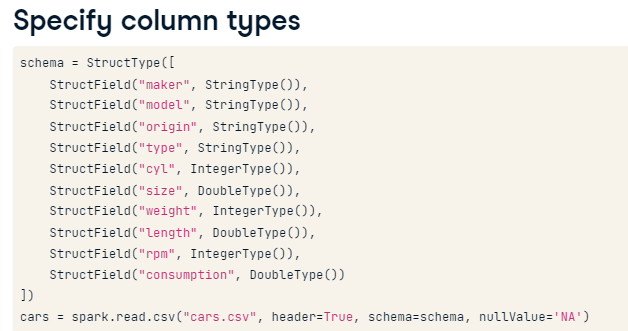

In [4]:
# display specify column types

from IPython import display
display.Image("Images/22_specify_column_type.png")

In [5]:
# Code for part 1.3

# loading flights data
from pyspark.sql import SparkSession

# create spark session: spark
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

# read data from CSV file
flights = spark.read.csv('22_datasets/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# get number of records
print("The data contain %d records." % flights.count())

# view the first five records
flights.show(5)

# check column data types
print(flights.dtypes)

The data contain 50000 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| NULL|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| NULL|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


In [6]:
# Code for part 1.3 (continue)

# loading SMS spam data
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# load data from a delimited file
sms = spark.read.csv('22_datasets/sms.csv', sep=';', header=False, schema=schema)
sms.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)


### CHAPTER 2. Classification

#### Part 2.1 Data Preparation

* Ways to prepare data for building a Machine Learning model:
    * Dropping column: *'df.drop()'* 
    * Selecting column: *'df.select()'*
    * Filtering out missing values: *'df.filter('cyl IS NULL').count()'*
    * Drop missing values: *'df.dropna()'*
    * Creating new columns: *'df.withColumn('newCol', operation)'*
    * Indexing categorical columns: *'StringIndexer(inputCol, outputCol).fit(df).transform(df)'*
    * Assembling columns: *'VectorAssembler(inpotCols, outputCol)'*

In [7]:
# Code for part 2.1

# removing columns and rows

# remove the 'flight'column
flights_drop_column = flights.drop('flight')

# number of records with missing 'delay' values
flights_drop_column.filter('delay IS NULL').count()

# remove records with missing 'delay' values
flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# remove records with missing values in any column and get the number of remaining rows
flights_none_missing = flights_valid_delay.dropna()
print(flights_none_missing.count())

47022


In [8]:
# Code for part 2.1 (continue)

# column manipulation
from pyspark.sql.functions import round

# convert 'mile' to 'km' and drop 'mile' column
flights = flights_none_missing
flights_km = flights.withColumn('km', round(flights.mile * 1.60934, 0)).drop('mile')

# create 'label' column indicating whether flights delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights.delay >= 15).cast('integer'))
flights_km.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+


In [9]:
# Code for part 2.1 (continue)

# categorical columns
from pyspark.ml.feature import StringIndexer

# create an indexer
flights = flights_km
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# indexer identifies categories in the data
indexer_model = indexer.fit(flights)

# indexer creates a new column with numeric index values
flights_indexed = indexer_model.transform(flights)

# repeat the same process for other categorical columns
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)


+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|        0.0|    0.0|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|        0.0|    1.0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|        1.0|    0.0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|        0.0|    1.0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|        1.0|    0.0|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+


In [10]:
# Code for part 2.1 (continue)

# assembling columns
from pyspark.ml.feature import VectorAssembler

# create an assembler object
flights = flights_indexed
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow', 'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')

# consolidate predictor columns
flights_assembled = assembler.transform(flights)

# check the column
flights_assembled.select('features', 'delay').show(5)

+--------------------+-----+
|            features|delay|
+--------------------+-----+
|[0.0,22.0,2.0,0.0...|   30|
|[2.0,20.0,4.0,0.0...|   -8|
|[9.0,13.0,1.0,1.0...|   -5|
|[5.0,2.0,1.0,0.0,...|    2|
|[7.0,2.0,6.0,1.0,...|   54|
+--------------------+-----+


#### Part 2.2 Decision Tree

* It is constructed using an algorithm called "Recursive Partitioning"
* Each node can be split with the most informative predictor
* This process repeats until certain criteria are met
* Building Decision Tree model:
    1. Train/Test split is essential for building machine learning models with *'.randomSplit()'* method
    2. Create a Decision Tree Classifier with *'DecisionTreeClassifier()'* method
    3. Learn from training data with *'.fit()'* method
    4. Make predictions on testing data with *'.transform()'* method, which adds new columns to the dataframe to display prediction and probability of predictions
    5. A confusion matrix can be used to describe the performance of a model on testing data, which has four values: true positive (TP), true negative (TN), false positive (FP), and false negative (FN)
    

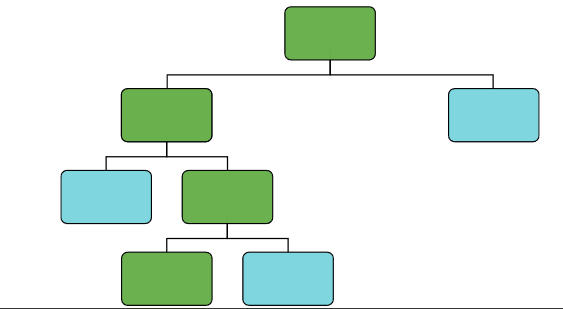

In [11]:
# display a decision tree model

from IPython import display
display.Image("Images/22_decision_tree.png")



In [12]:
# Code for part 2.2

# train/test split

# split into training and testing sets in a 80:20 ratio
flights = flights_assembled
flights_train, flights_test = flights.randomSplit([.8, .2], seed=43)

# check that training set has around 80% of records
training_ratio = flights_train.count() / flights.count()
print(training_ratio)


0.8025392369529156


In [13]:
# Code for part 2.2 (continue)

# build a Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier

# create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)

# create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)


+-----+----------+---------------------------------------+
|label|prediction|probability                            |
+-----+----------+---------------------------------------+
|1    |0.0       |[0.5678251121076233,0.4321748878923767]|
|1    |0.0       |[0.5678251121076233,0.4321748878923767]|
|0    |1.0       |[0.3111574812814533,0.6888425187185467]|
|1    |1.0       |[0.3111574812814533,0.6888425187185467]|
|1    |1.0       |[0.3111574812814533,0.6888425187185467]|
+-----+----------+---------------------------------------+


In [14]:
# Code for part 2.2 (continue)

# evaluate the Decision Tree

# create a confusion matrix
cm = prediction.groupBy('label', 'prediction').count()
cm.show()

# calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1161|
|    0|       0.0| 2323|
|    1|       1.0| 3602|
|    0|       1.0| 2199|
+-----+----------+-----+
0.6381260096930533


#### Part 2.3 Logistic Regression

* It uses a logistic function to model a binary target
* The value of y-axis is between 0 and 1
* The value above the threshold is considered TRUE, below is FALSE
* Use *'MultiClassificationEvaluator'* to evaluate with different metrics
* ROC curve plots the True Positive rate VS. False Positive rate when the threshold changes from 0 to 1
* AUC summarizes the ROC into a single number, the area under the curve

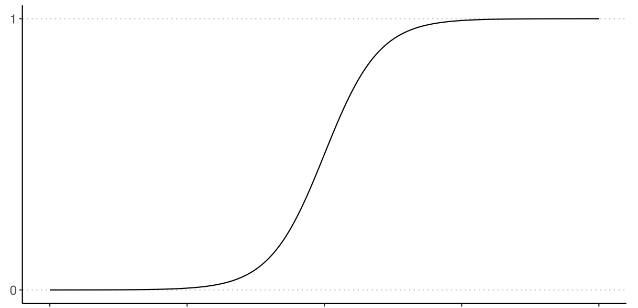

In [15]:
# display logistic regression curve
from IPython import display

display.Image("Images/22_logistic_curve.png")

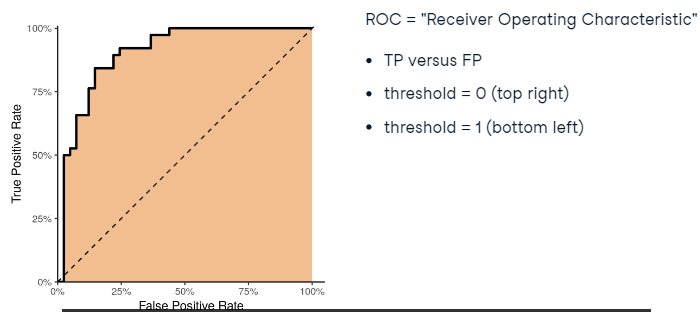

In [16]:
# display ROC curve
from IPython import display

display.Image("Images/22_roc_curve.png")

In [17]:
# Code for part 2.3 

# build a Logistic Regression model
from pyspark.ml.classification import LogisticRegression

# create a classifier object and train on the training data
logistic = LogisticRegression().fit(flights_train)

# create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1705|
|    0|       0.0| 2561|
|    1|       1.0| 3058|
|    0|       1.0| 1961|
+-----+----------+-----+


In [19]:
# Code for part 2.3 (continue)

# evaluate a Logistic Regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# calculate precision and recall
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()
precision = TP/ (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall = {:.2f}'.format(precision, recall))

# find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})


# find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName:"areaUnderROC"})
print('weighted precision = {:.2f}\nAUC = {:.2f}'.format(weighted_precision, auc))

precision = 0.61
recall = 0.64
weighted precision = 0.60
AUC = 0.64


#### Part 2.4 Turning text into tables

* Text data preparation is challenging, we need to turn them into tables
* Starting with a collection of documents, each document will become a record in the table
* The text in each document will be mapped to columns in the table
    1. Remove punctuation with regular expression
       * *'from pyspark.sql.functions import regexp_replace'*
    2. Tokenize the document into words or tokens
       * *'from pyspark.ml.feature import Tokenizer'*
    3. Remove stop words or common words that do not carry too much information 
       * *'from pyspark.ml.feature import StopWordsRemover'*
    4. Then we get a table called "term-document matrix"
    5. Use feature hashing to convert the words into numbers
       * *'from pyspark.ml.feature import HashingTF'*
    6. Convert the result into TF-IDF
       * *'from pyspark.ml.feature import IDF'*

In [27]:
# Code for part 2.4

# punctuation, numbers and tokens
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer

# get SMS data
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])
sms = spark.read.csv('22_datasets/sms.csv', header=False, sep=';', schema=schema)
sms.show(5)

# remove punctuation
wrangled = sms.withColumn('text', regexp_replace(sms.text, '[_():;,.!?\\-]', ' '))
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, '[0-9]', ' '))

# merge multiple spaces
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, ' +', ' '))

# split the text into words
wrangled = Tokenizer(inputCol='text', outputCol='words').transform(wrangled)
wrangled.show(4, truncate=False)

+---+--------------------+-----+
| id|                text|label|
+---+--------------------+-----+
|  1|Sorry, I'll call ...|    0|
|  2|Dont worry. I gue...|    0|
|  3|Call FREEPHONE 08...|    1|
|  4|Win a 1000 cash p...|    1|
|  5|Go until jurong p...|    0|
+---+--------------------+-----+
only showing top 5 rows

+---+----------------------------------+-----+------------------------------------------+
|id |text                              |label|words                                     |
+---+----------------------------------+-----+------------------------------------------+
|1  |Sorry I'll call later in meeting  |0    |[sorry, i'll, call, later, in, meeting]   |
|2  |Dont worry I guess he's busy      |0    |[dont, worry, i, guess, he's, busy]       |
|3  |Call FREEPHONE now                |1    |[call, freephone, now]                    |
|4  |Win a cash prize or a prize worth |1    |[win, a, cash, prize, or, a, prize, worth]|
+---+----------------------------------+-----+--

In [28]:
# Code for part 2.4 (continue)

# stop words and hashing
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

# get an updated version of sms
sms = wrangled
# remove stop words
wrangled = StopWordsRemover(inputCol='words', outputCol='terms').transform(sms)

# apply the hashing trick
wrangled = HashingTF(inputCol='terms', outputCol='hash', numFeatures=1024).transform(wrangled)

# convert hashed symbols to TF-IDF
tf_idf = IDF(inputCol='hash', outputCol='features').fit(wrangled).transform(wrangled)
tf_idf.select('terms', 'features').show(4, truncate=False)

+--------------------------------+----------------------------------------------------------------------------------------------------+
|terms                           |features                                                                                            |
+--------------------------------+----------------------------------------------------------------------------------------------------+
|[sorry, call, later, meeting]   |(1024,[138,384,577,996],[2.273418200008753,3.6288353225642043,3.5890949939146903,4.104259019279279])|
|[dont, worry, guess, busy]      |(1024,[215,233,276,329],[3.9913186080986836,3.3790235241678332,4.734227298217693,4.58299632849377]) |
|[call, freephone]               |(1024,[133,138],[5.367951058306837,2.273418200008753])                                              |
|[win, cash, prize, prize, worth]|(1024,[31,47,62,389],[3.6632029660684124,4.754846585420428,4.072170704727778,7.064594791043114])    |
+--------------------------------+--------------

In [30]:
# Code for part 2.4 (continue)

# training a spam classifier
from pyspark.ml.classification import LogisticRegression

# split data into training and testing sets
sms = tf_idf
sms_train, sms_test = sms.randomSplit([.8, .2], seed=13)

# fit a Logistic Regression model to the training data
logistic = LogisticRegression(regParam=0.2).fit(sms_train)

# make predictions on the testing data
prediction = logistic.transform(sms_test)

# create a confusion matrix, comparing prediction to known labels
prediction.groupBy('label', 'prediction').count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   41|
|    0|       0.0|  948|
|    1|       1.0|  105|
|    0|       1.0|    2|
+-----+----------+-----+


### CHAPTER 3. Regression

#### Part 3.1 One-Hot Encoding

*